# Setup

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from plotnine import *

Default "reasonable" parameter values based on those used to produce the exponential distribution in Lecheval

In [3]:
#Parameters for the simulation
N      = 1000           # Total number of ants

#Parameters from the equation, accessed by name
p    = {
"alpha"  : 0.75,            # Per capita rate of spontaneous discoveries
"s"      : 3.5,             # Per capita rate of ant leaving trail per distance
"gamma1" : 0.1,             # Range of foraging scouts
"gamma2" : 0.021,           # Range of recruitment activity
"gamma3" : 0.021,           # Range of influence of pheromone
"K"      : 1,               # Inertial effects that may affect pheromones
"n1"     : 20,              # Individual ant's contribution to rate of recruitment (orig. eta1)
"n2"     : 20               # Pheromone strength of trail (originally eta2)       
}

Default time to numerically integrate over

In [4]:
start = 0.0
stop  = 1
step  = 0.01
tspan = np.arange(start, stop+step, step)

Returns a system differential equations representing the change in number of ants on each trail

In [5]:
def dx_dt(x, t, Q,D,betaB,betaS,J):
        """
        Creates a list of J equations describing the number of ants
        on each of the J trails. (Eqn i corresponds to food source i)
        """
        system = np.zeros(J)
        system = (p["alpha"]* np.exp(-p["gamma1"]*D) + (p["gamma2"]/D)*betaB*x)*(N-sum(x)) - (p["s"]*D*x)/(p["K"]+ (p["gamma3"]/D)*betaS*x)
        return system


Numerically integrates the system of trails with given quality and distances

In [6]:
def simulation(Q, D, tspan = tspan, x0 = np.empty(0)):
    """
    Returns the results of numerically integrating the system
    with the input distances and qualities over the given time span
    returns an array of the number of ants on each trail over time
    """
    betaB = p["n1"] * Q
    betaS = p["n2"] * Q
    J = len(Q)
    if not x0.any():
        x0 = np.zeros(J)
    #Numerically integrates. Columns: trail, Rows: time step
    xs = odeint(dx_dt, x0, tspan, args=(Q,D,betaB,betaS,J)) 

    return xs

Numerically solves for the non-trivial equilibrium points of the system. That is, the point at which no single food source dominates and the number of ants on each trail has reached steady state. The default initial guess is that this equilibrium occurs when an equal proportion of all available ants are on each trail.

In [7]:
def find_eq_point(Q, D, guess = None):
    print(N)
    betaB = p["n1"] * Q
    betaS = p["n2"] * Q
    J = len(Q)
    
    if guess == None:
        guess = np.repeat(N/J, J)
        
    #The None is necessary here because dx_dt must take in a time
    #input when using odeint even though it is autonomous.
    eq = fsolve(dx_dt, guess, args=(None, Q, D, betaB, betaS, J))
    return eq

#Testing
#find_eq_point(np.array([5,10,10]), np.array([20,20,20]))

Plot the results of numerically integrating on a time axis

In [8]:
def plot_integrate(xs, Q, D, display=True, save=False):
    """
    Plots the results of numerical integration from integrate
    """

    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
    total_ants = np.zeros(len(xs[0]))
    for i in range(len(xs[0])):
        ax.plot(tspan, xs[:,i], label=f"Trail {i}")
    #ax.plot(tspan, np.sum(xs, axis=1), label="Total Ants on Trail", linestyle="dashed")
    #Find point at which we are using pretty much all the ants
    all_ants = 0
    for i in range(len(xs)):
        if np.sum(xs, axis=1)[i] > 0.99*N:
            all_ants = tspan[i]
            break
    #ax.axvline(x = all_ants, linestyle ="dashed")
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Proportion of Ants")
    ax.set_title("Proportion of ants on trails over time")
    plt.ylim([0, N])
    if save:
        plt.savefig(f"Plots/Plot-{datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')}.png")
    if display:
        plt.show()

Plot the results of numerically integrating 2 trails in phase space

In [9]:
def plot_2dphase(xs_array, Q, D, display=True, save=False):
    """
    Plot the results of numerical integration from integrate in phase space
    """
    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)

    for i in range(len(xs_array)):
        xs = xs_array[i]
        if i == 0:
             ax.plot(xs[:,0], xs[:,1], color="black")
        else:
             ax.plot(xs[:,0], xs[:,1], color="red")
            
    ax.set_xlabel(f"Trail A (Q:{Q[0]} D:{D[0]})")
    ax.axhline(y = 0, color = "black")
    ax.axvline(x = 0, color ="black")

    ax.set_ylabel(f"Trail B (Q:{Q[1]} D:{D[1]})")
    ax.set_title("Ants on trails phase space")
    #Draw dotted line that represents the points at which all ants are on the trail
    #ax.plot([0, N], [N, 0], linestyle="--")
    #ax.set_aspect('equal', 'box')    
    if save:
        plt.savefig(f"Plots/Plot-{datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')}.png")
    if display:
        plt.show()

In [10]:
def plot_2dphase_norm(xs_array, Q, D, display=True, save=False):
    """
    Plot the results of numerical integration from integrate in phase space
    """
    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
    for i in range(len(xs_array)):
        xs = xs_array[i]
        ax.plot(xs[:,0], xs[:,1], color=(i/len(xs_array),0, 1-i/len(xs_array)))
    
    print(Q, D)
    ax.set_xlabel(f"Trail A (Q:{Q[0]} D:{D[0]})")
    ax.axhline(y = 0, color = "black")
    ax.axvline(x = 0, color ="black")

    ax.set_ylabel(f"Trail B (Q:{Q[1]} D:{D[1]})")
    ax.set_title("Phase portrait for varying values of N")
    
    plt.xlim([0,1])
    plt.ylim([0,1])
    #Draw dotted line that represents the points at which all ants are on the trail
    #ax.plot([0, N], [N, 0], linestyle="--")
    #ax.set_aspect('equal', 'box')    
    if save:
        plt.savefig(f"Plots/Plot-{datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')}.png")
    if display:
        plt.show()

# Testing and Plotting

Plot a sweep of population in phase space

[10, 40], 
[10, 30]

[10, 20], 
[10, 15]

[6, 20], 
[5, 15]

[6, 40], 
[5, 30]

Q = np.array([12, 40])
D = np.array([10, 30])

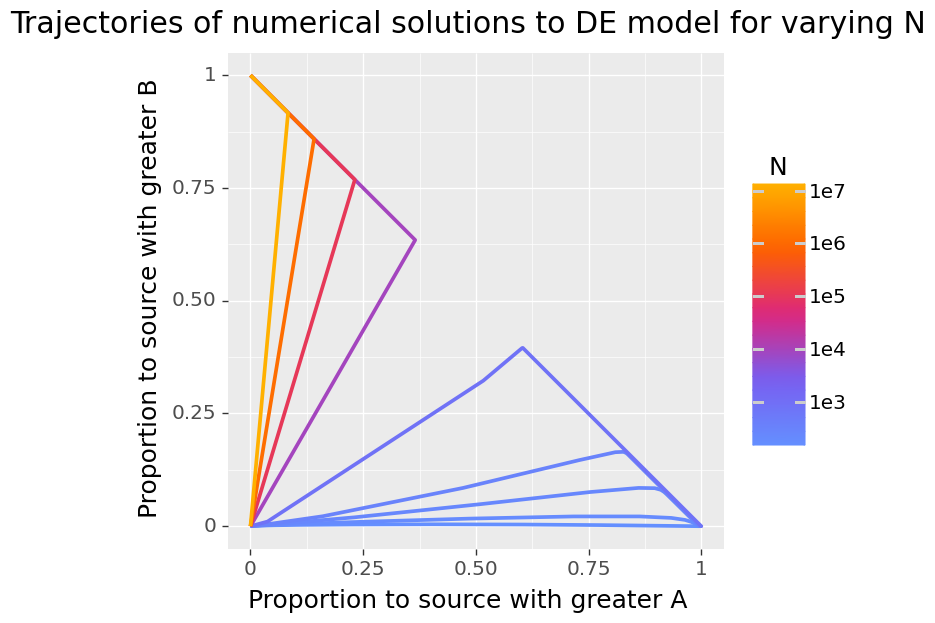

<ggplot: (141346047422)>

In [281]:
p    = {
    "alpha"  : 0.75,            # Per capita rate of spontaneous discoveries
    "s"      : 3.5,             # Per capita rate of ant leaving trail per distance
    "gamma1" : 0.1,             # Range of foraging scouts
    "gamma2" : 0.021,           # Range of recruitment activity
    "gamma3" : 0.021,           # Range of influence of pheromone
    "K"      : 1,               # Inertial effects that may affect pheromones
    "n1"     : 20,              # Individual ant's contribution to rate of recruitment (orig. eta1)
    "n2"     : 20               # Pheromone strength of trail (originally eta2)       
    }

Q = np.array([10.0, 40.0])
D = np.array([10.0, 30.0])

start = 0.0
stop  = 10
step  = 0.01
tspan = np.arange(start, stop+step, step)

xs_array = []
N_array = []
tspans = np.empty(0)
Ns = [2.3, 2.4, 2.5, 2.6, 3, 4, 5, 6, 7]

for i in range(len(Ns)):
    N = 10**Ns[i]
    tspan[-1] = N
    xs_array += [simulation(Q, D, tspan=tspan, x0 = np.array([0,0]))/N]
    N_array += [10**Ns[i]]
    stopN  = stop / 10**Ns[i]
    stepN  = step / 10**Ns[i]
    
    tspan = np.arange(start, stop+step, step)
    tspans = np.append(tspans, tspan)

#Turn trajectories into a dataframe
#One column is x's, next is y's, one for N
d = {
    "trajectory-x": np.empty(0),
    "trajectory-y": np.empty(0),
    "N": np.empty(0),
    "t": tspans
}

for i in range(len(xs_array)):
    d["trajectory-x"] = np.append(d["trajectory-x"] ,xs_array[i][:,0])
    d["trajectory-y"] = np.append(d["trajectory-y"] ,xs_array[i][:,1])
    d["N"] = np.append(d["N"], np.repeat(N_array[i], len(xs_array[i][:,0])))
df = pd.DataFrame(d)
#display(df)
"""
gg = (ggplot(df, aes(x="tspans", y = "trajectory-x", group="N", color="N"))
     + geom_path(size=1.5)
     + scale_color_gradientn(["#648FFF","#785EF0", "#DC267F", "#FE6100", "#FFB000"], trans="log10", guide=False)
     + scale_x_log10()
     + labs(title = "Proportion of ants on trail \n to closest food source",
         color="  N")
      + xlab ("Time")
      + ylab ("Proportion")
      + theme_grey(base_size=18)
     )
display(gg)
gg = (ggplot(df, aes(x="tspans", y = "trajectory-y", group="N", color="N"))
     + geom_path(size=1.5)
     + scale_color_gradientn(["#648FFF","#785EF0", "#DC267F", "#FE6100", "#FFB000"], trans="log10", guide=False)
     + scale_x_log10()
     + labs(title = "Proportion of ants on trail \n to source with greatest quality-distance ratio",
            color="  N")
     + xlab ("Time")
     + ylab ("Proportion")
      + theme_grey(base_size=18)
     )
display(gg)
"""

ggqd = (ggplot(df, aes(x="trajectory-x", y="trajectory-y", group="N", color="N"))
       + geom_path(size=1.5)
       + scale_color_gradientn(["#648FFF","#785EF0", "#DC267F", "#FE6100", "#FFB000"], trans="log10")
       + labs(title = "Trajectories of numerical solutions to DE model for varying N",
             color="  N")
       #+ xlab(f"Q: {Q[0]}, D: {D[0]}")
       #+ ylab(f"Q: {Q[1]}, D: {D[1]}")
       + xlim([0,1])
       + ylim([0,1])
       + theme_grey(base_size=18)
       + theme(aspect_ratio=1,
               
              )
       + xlab("Proportion to source with greater A")
       + ylab(f"Proportion to source with greater B")
       )
display(ggqd)

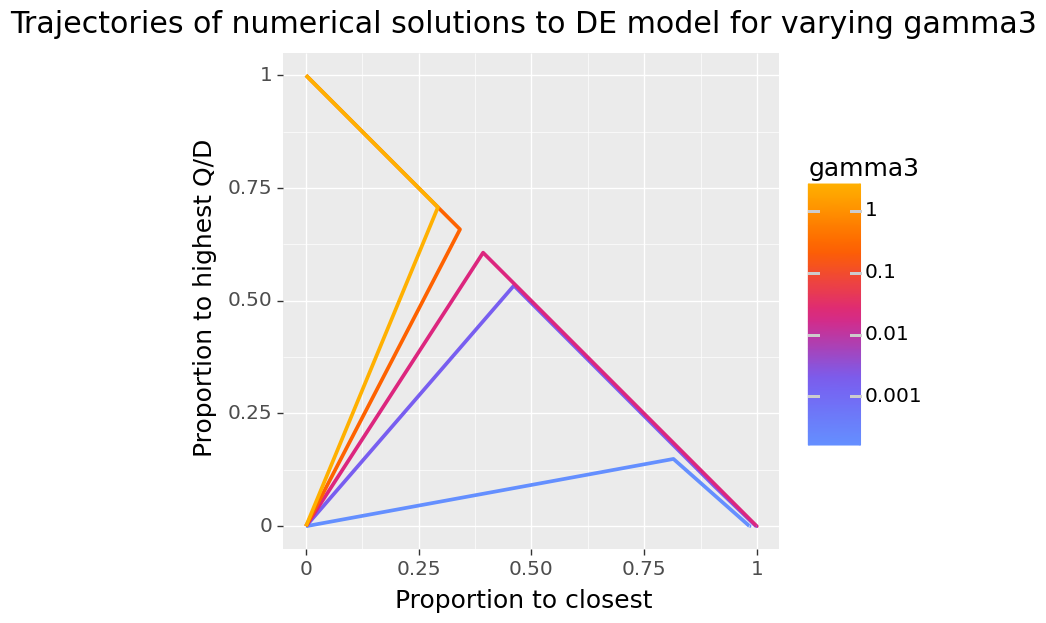

<ggplot: (137849108776)>

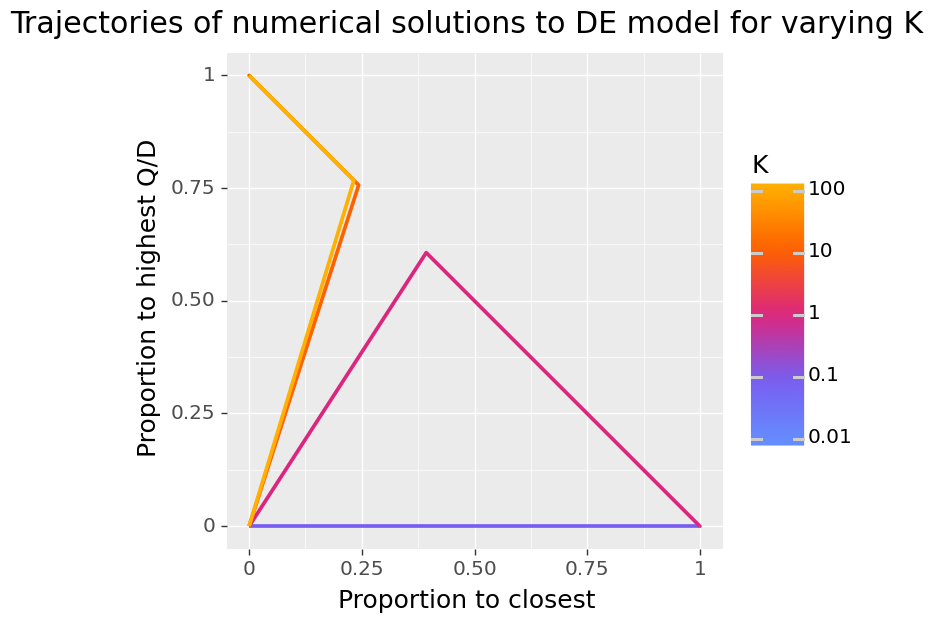

<ggplot: (137851777506)>

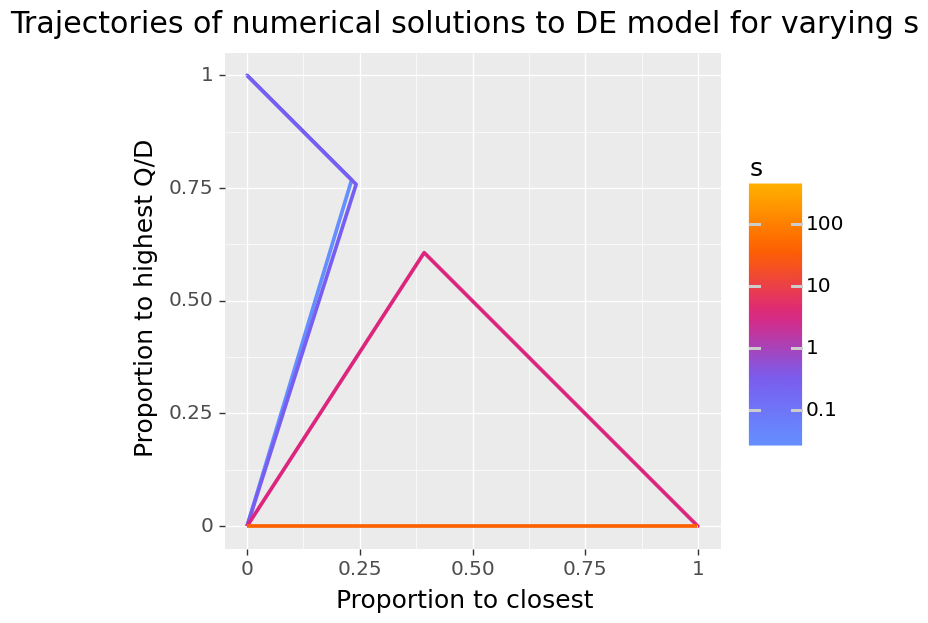

<ggplot: (137850382448)>

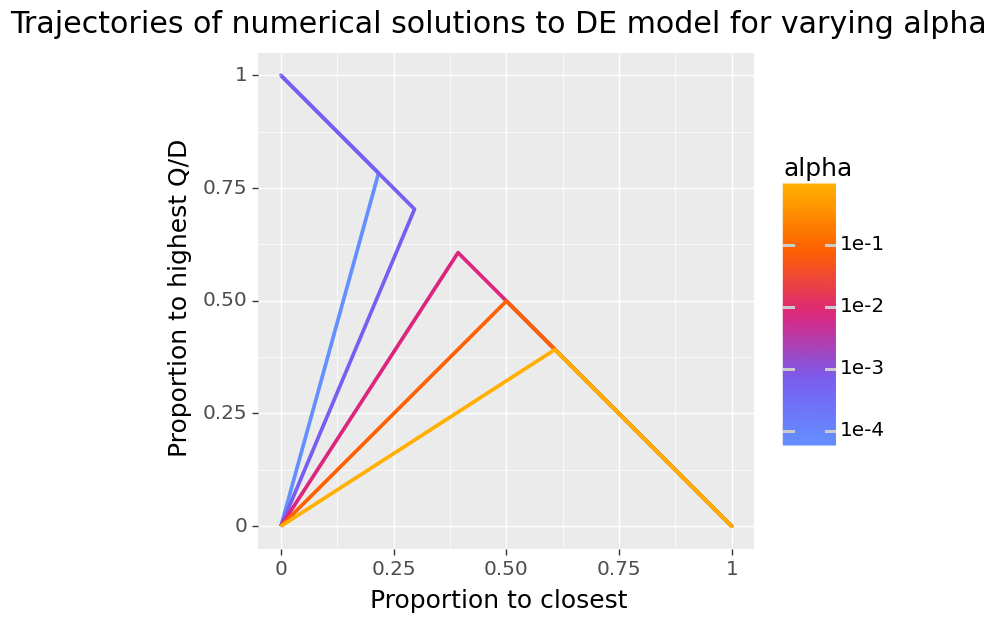

<ggplot: (137850735348)>

In [57]:
Q = np.array([10, 40.0])
D = np.array([10.0, 30.0])

start = 0
stop  = 100
step  = 0.1
tspan = np.arange(start, stop+step, step)
tspan[-1] = N

plist = ["gamma3", "K", "s", "alpha"]

N = 1000
#tspans = np.empty(0)
for key in plist:
    p    = {
    "alpha"  : 0.0075,            # Per capita rate of spontaneous discoveries
    "s"      : 3.5,             # Per capita rate of ant leaving trail per distance
    "gamma1" : 0.1,             # Range of foraging scouts
    "gamma2" : 0.021,           # Range of recruitment activity
    "gamma3" : 0.021,           # Range of influence of pheromone
    "K"      : 1,               # Inertial effects that may affect pheromones
    "n1"     : 20,              # Individual ant's contribution to rate of recruitment (orig. eta1)
    "n2"     : 20               # Pheromone strength of trail (originally eta2)       
    }
    xs_array = []
    param = p[key]
    params = [param / 100, param / 10, param, param * 10, param * 100]
    for i in range(len(params)):
        p[key] = params[i]
        xs_array += [simulation(Q, D, tspan=tspan, x0 = np.array([0,0]))/N]
        #tspan = np.arange(start, stop+step, step)
        #tspans = np.append(tspans, tspan)


    #Turn trajectories into a dataframe
    #One column is x's, next is y's, one for N
    d = {}
    d = {
        "trajectory-x": np.empty(0),
        "trajectory-y": np.empty(0),
        key: np.empty(0),
    }
    for i in range(len(xs_array)):
        d["trajectory-x"] = np.append(d["trajectory-x"] ,xs_array[i][:,0])
        d["trajectory-y"] = np.append(d["trajectory-y"] ,xs_array[i][:,1])
        d[key] = np.append(d[key], np.repeat(params[i], len(xs_array[i][:,0])))
    df = pd.DataFrame(d)
    #display(df)
    ggqd = (ggplot(df, aes(x="trajectory-x", y="trajectory-y", group=key, color=key))
           + geom_path(size=1.5)
           + scale_color_gradientn(["#648FFF","#785EF0", "#DC267F", "#FE6100", "#FFB000"], trans="log10")
           + labs(title = f"Trajectories of numerical solutions to DE model for varying {key}",
                 color=key)
           #+ xlab(f"Q: {Q[0]}, D: {D[0]}")
           #+ ylab(f"Q: {Q[1]}, D: {D[1]}")
           + xlim([0,1])
           + ylim([0,1])
           + theme_grey(base_size=18)
           + theme(aspect_ratio=1,

                  )
           + xlab("Proportion to closest")
           + ylab(f"Proportion to highest Q/D")
           )
    display(ggqd)
#plot_2dphase_norm(np.array(xs_array), Q, D)

## Food source zone

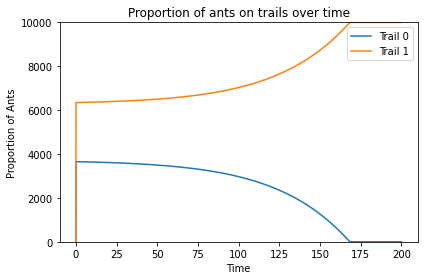

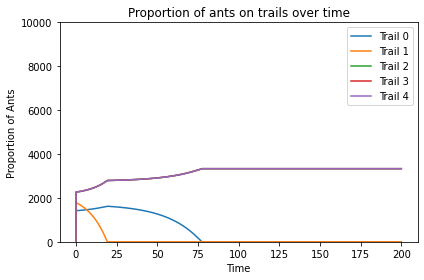

In [30]:
p    = {
    "alpha"  : 0.75,            # Per capita rate of spontaneous discoveries
    "s"      : 3.5,             # Per capita rate of ant leaving trail per distance
    "gamma1" : 0.1,             # Range of foraging scouts
    "gamma2" : 0.021,           # Range of recruitment activity
    "gamma3" : 0.021,           # Range of influence of pheromone
    "K"      : 1,               # Inertial effects that may affect pheromones
    "n1"     : 20,              # Individual ant's contribution to rate of recruitment (orig. eta1)
    "n2"     : 20               # Pheromone strength of trail (originally eta2)       
}

start = 0.0
stop  = 200
step  = 0.001
tspan = np.arange(start, stop+step, step)

N = 10000
Q = np.array([10, 40.0])
D = np.array([10.0, 30.0])

plot_integrate(simulation(Q, D, tspan = tspan, x0 = np.empty(0)), Q, D)


Q = np.array([10, 40, 15, 15, 15])
D = np.array([10, 30, 20, 20, 30])

plot_integrate(simulation(Q, D, tspan = tspan, x0 = np.empty(0)), Q, D)
